<a href="https://colab.research.google.com/github/drovosekovanton/Skillfactory_game/blob/master/Skillfactory_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Импорт используемых библиотек

In [0]:
import pandas as pd
import numpy as np
from pathlib import PurePath
from collections import namedtuple
from google.colab import drive
import glob
from datetime import datetime
import progressbar

# mount root of your google drive to '/content/drive'
drive.mount('/content/drive')
# suppose that dataset is inside 
# 'Colab Notebooks/Skillfactory_game_data' folder
file_prefix = PurePath('/content/drive/My Drive/Colab Notebooks'
                       '/Skillfactory_game_data')


### `Описание файлов датасета`

**informations_households.csv**

Информация о датчиках энергопотребления и краткие сведения о домах, в которых эти датчики установлены. Столбцы датафрейма:

| LCLid | stdorToU | Acorn | Acorn_grouped | file |
|:-|:-|:-|:-|:-|
| id датчика | форма оплаты за электроэнергию в доме, в котором установлен датчик (Std – стандартная, ToU – Time of Use, оплата зависит от времени суток) | информация о том, к какой категории потребителей по системе ACORN относится семья, проживающая в данном доме |  | имя файла, содержащего показатели счётчиков |


**halfhourly_dataset\block_{0 - 111}.csv**

Архив содержит 112 файлов, содержащих данные об энергопотреблении, получаемые с каждого счётчика 1 раз в 30 минут. Каждый файл содержит информацию с датчиков, установленных в одном доме. Столбцы датафрейма:

| LCLid | tstp | energy(kWh/hh) |
|:-|:-|:-|
| id датчика | дата и время фиксации показателей | уровень энергопотребления |

**hourly_dataset\block_{0 - 111}.csv**

Архив содержит 112 файлов, содержащих данные об энергопотреблении, получаемые с каждого счётчика 1 раз в час. Каждый файл содержит информацию с датчиков, установленных в одном доме. Столбцы датафрейма:

| LCLid | tstp | energy |
|:-|:-|:-|
| id датчика | дата и время фиксации показателей | уровень энергопотребления |

**daily_dataset\daily_dataset\block_{0 - 111}.csv**

Архив содержит 112 файлов, содержащих обобщённые данные об энергопотреблении за каждые сутки. Каждый файл содержит информацию с датчиков, установленных в одном доме. Столбцы датафрейма:

| LCLid | day | energy_median | energy_mean | energy_max |energy_count|energy_std|energy_sum|energy_min|
|:-|:-|:-|:-|:-|:-|:-|:-|:-|
|id датчика|дата|медиана суточных показателей|среднее арифметическое суточных показателей|максимальное значение энергопотребления, зафиксированное датчиком в течение дня|количество показателей, зафиксированных датчиком в течение дня|стандартное отклонение|сумма значений всех показателей|минимальное значение энергопотребления, зафиксированное датчиком в течение дня|

**acorn_details.csv**

Данные о группах потребителей согласно классификации ACORN. При характеристике групп в данном датафрейме используется сравнение каждой группы с общенациональными показателями. Так, если значение ячейки по какому-либо показателю составляет 150 это означает, что в рассматриваемой группе этот показатель встречается в 1,5 раза чаще, чем в целом по стране. Столбцы датафрейма:
- MAIN CATEGORIES, CATEGORIES, REFERENCE – показатели, по которым осуществляется сравнение групп;
- ACORN-A, ACORN-B, ACORN-C, ACORN-D, ACORN-E, ACORN-F, ACORN-G, ACORN-H, ACORN-I, ACORN-J, ACORN-K, ACORN-L, ACORN-M, ACORN-N, ACORN-O, ACORN-P, ACORN-Q – частота встречаемости каждого из рассмотренных признаков в каждой группе.
Использование данного файла при проведении анализа не является обязательным

**weather_daily_darksky.csv**

Обобщённые данные о погоде за день. Столбцы датафрейма:
- temperatureMax – максимальное значение температуры воздуха;
- temperatureMaxTime – время, когда была зафиксирована максимальная температура воздуха;
- windBearing – направление ветра (по азимуту);
- icon – стандартизованное словесное описание погодных условий;
- dewPoint – точка росы;
- temperatureMinTime – время, когда была зафиксирована минимальная температура воздуха;
- cloudCover – облачность;
- windSpeed – скорость ветра;
- pressure – атмосферное давление;
- apparentTemperatureMinTime – время, когда была зафиксирована минимальная температура комфорта;
- apparentTemperatureHigh – дневная температура комфорта;
- precipType – тип осадков;
- visibility – видимость (в милях);
- humidity – относительная влажность;
- apparentTemperatureHighTime – время, когда была зафиксирована дневная температура комфорта;
- apparentTemperatureLow – ночная температура комфорта;
- apparentTemperatureMax – максимальная температура комфорта;
- uvIndex – UV-индекс;
- time – время начала сбора данных;
- sunsetTime – время заката;
- temperatureLow – минимальная ночная температура;
- temperatureMin – минимальная температура за сутки;
- temperatureHigh – максимальная дневная температура;
- sunriseTime – время восхода;
- temperatureHighTime – время, когда была зафиксирована максимальная дневная температура;
- uvIndexTime – время, когда был зафиксирован максимальный UV-индекс;
- summary – словесное описание погоды в течение дня (не рекомендуется использовать для автоматизированного анализа!);
- temperatureLowTime – время, когда была зафиксирована минимальная ночная температура;
- apparentTemperatureMin – минимальная температура комфорта;
- apparentTemperatureMaxTime – время, когда была зафиксирована максимальная температура комфорта за сутки;
- apparentTemperatureLowTime – время, когда была зафиксирована минимальная ночная температура комфорта; 
- moonPhase – фаза луны.

**weather_hourly_darksky.csv**

Почасовые сведения о погоде. Столбцы датафрейма:
- visibility – видимость в милях;
- windBearing – направление ветра (по азимуту);
- temperature – температура воздуха;
- time – время записи показателей;
- dewPoint – точка росы;
- pressure – атмосферное давление;
- apparentTemperature – температура комфорта;
- windSpeed – скорость ветра;
- precipType – тип осадков;
- icon – стандартизованное словесное описание погодных условий;
- humidity – относительная влажность;
- summary – нестандартизованное словесное описание погодных условий.

### Загрузка сводных данных

In [0]:
informations_households = pd.read_csv(
    file_prefix / 'informations_households.csv',
    index_col='LCLid'
    )
daily_dataset = pd.read_csv(
    file_prefix / 'daily_dataset' / 'daily_dataset.csv.zip',
    index_col='LCLid'
    )
acorn_details = pd.read_csv(
    file_prefix / 'acorn_details.csv',
    encoding='cp1251'
    )
weather_daily_darksky = pd.read_csv(
    file_prefix / 'weather_daily_darksky.csv'
    )
weather_hourly_darksky = pd.read_csv(
    file_prefix / 'weather_hourly_darksky.csv'
    )

### Общие данные по ACORN

In [0]:
# Details on the acorn groups and their profile of the people in the group
# At a national scale, the index is 100
# if for one column the value is 150 it means that there are 1.5 times more people
# with this attribute in the ACORN group than at the national scale
display(acorn_details.head(20))

display(acorn_details['MAIN CATEGORIES'].unique())
# each main category has its subcategory
display(acorn_details[acorn_details['MAIN CATEGORIES'] == 'FAMILY']['CATEGORIES'].unique())
# and a reference for a certain subcategory
# acorn_details['REFERENCE'].unique()
# acorn_details[acorn_details['REFERENCE'] == 'Being mugged and robbed']

,MAIN CATEGORIES,CATEGORIES,REFERENCE,ACORN-A,ACORN-B,ACORN-C,ACORN-D,ACORN-E,ACORN-F,ACORN-G,ACORN-H,ACORN-I,ACORN-J,ACORN-K,ACORN-L,ACORN-M,ACORN-N,ACORN-O,ACORN-P,ACORN-Q
0,POPULATION,Age,Age 0-4,77.0,83.0,72.0,100.0,120.0,77.0,97.0,97.0,63.0,119.0,67.0,114.0,113.0,89.0,123.0,138.0,133.0
1,POPULATION,Age,Age 5-17,117.0,109.0,87.0,69.0,94.0,95.0,102.0,106.0,67.0,95.0,64.0,108.0,116.0,86.0,89.0,136.0,106.0
2,POPULATION,Age,Age 18-24,64.0,73.0,67.0,107.0,100.0,71.0,83.0,89.0,62.0,104.0,459.0,97.0,96.0,86.0,117.0,109.0,110.0
3,POPULATION,Age,Age 25-34,52.0,63.0,62.0,197.0,151.0,66.0,90.0,88.0,63.0,132.0,145.0,109.0,96.0,90.0,140.0,120.0,120.0
4,POPULATION,Age,Age 35-49,102.0,105.0,91.0,124.0,118.0,93.0,102.0,103.0,76.0,111.0,67.0,99.0,98.0,90.0,102.0,103.0,100.0
5,POPULATION,Age,Age 50-64,124.0,121.0,120.0,72.0,82.0,126.0,109.0,107.0,112.0,90.0,41.0,95.0,96.0,103.0,89.0,78.0,89.0
6,POPULATION,Age,Aged 65-74,125.0,120.0,152.0,55.0,61.0,144.0,108.0,104.0,182.0,72.0,29.0,91.0,93.0,125.0,73.0,59.0,76.0
7,POPULATION,Age,Aged 75 plus,112.0,103.0,157.0,49.0,57.0,117.0,98.0,96.0,220.0,66.0,32.0,87.0,96.0,152.0,72.0,56.0,76.0
8,POPULATION,Geography,England,107.0,101.0,103.0,114.0,106.0,75.0,107.0,106.0,102.0,106.0,95.0,93.0,97.0,89.0,97.0,110.0,97.0
9,POPULATION,Geography,Northern Ireland,30.0,95.0,45.0,2.0,49.0,462.0,53.0,104.0,30.0,91.0,56.0,87.0,131.0,67.0,95.0,75.0,43.0


array(['POPULATION', 'HOUSING', 'FAMILY', 'ECONOMY', 'EDUCATION',
       'HEALTH', 'TRANSPORT', 'MARKETING CHANNELS', 'FINANCE', 'DIGITAL',
       'SHOPPING', 'CONTACT', 'ENVIRONMENT', 'COMMUNITY SAFETY',
       'LEISURE TIME'], dtype=object)

array(['Structure', 'Children in household', 'Household Size'],
      dtype=object)

In [0]:
# common details over population
display(acorn_details.drop_duplicates(subset=['MAIN CATEGORIES'])['MAIN CATEGORIES'])
display(acorn_details.drop_duplicates(subset=['MAIN CATEGORIES', 'CATEGORIES']).set_index(['MAIN CATEGORIES'])['CATEGORIES'])
display(acorn_details.drop_duplicates(subset=['MAIN CATEGORIES', 'CATEGORIES', 'REFERENCE']).set_index(['MAIN CATEGORIES', 'CATEGORIES'])['REFERENCE'])

0              POPULATION
35                HOUSING
59                 FAMILY
74                ECONOMY
108             EDUCATION
127                HEALTH
134             TRANSPORT
159    MARKETING CHANNELS
186               FINANCE
280               DIGITAL
652              SHOPPING
696               CONTACT
700           ENVIRONMENT
712      COMMUNITY SAFETY
734          LEISURE TIME
Name: MAIN CATEGORIES, dtype: object

MAIN CATEGORIES
POPULATION                                   Age
POPULATION                             Geography
POPULATION                             Ethnicity
POPULATION                      Country of Birth
POPULATION                              Religion
                              ...               
LEISURE TIME    Visit Pubs for a Drink - Evening
LEISURE TIME         Visit Pubs for a Meal - Day
LEISURE TIME     Visit Pubs for a Meal - Evening
LEISURE TIME            Restaurants - Most Often
LEISURE TIME            Holiday Destination/Type
Name: CATEGORIES, Length: 84, dtype: object

MAIN CATEGORIES  CATEGORIES              
POPULATION       Age                                           Age 0-4
                 Age                                          Age 5-17
                 Age                                         Age 18-24
                 Age                                         Age 25-34
                 Age                                         Age 35-49
                                                       ...            
LEISURE TIME     Holiday Destination/Type                         Asia
                 Holiday Destination/Type    Activity / Outdoor Sports
                 Holiday Destination/Type                       Cruise
                 Holiday Destination/Type                      Package
                 Holiday Destination/Type                Self-catering
Name: REFERENCE, Length: 826, dtype: object

### группы по ACORN среди потребителей в датасете

In [0]:
# группы потребителей по ACORN

display(informations_households['Acorn_grouped'].unique())
# Присутствует 'ACORN-U(nclassified)' который не принадлежит ни одной ACORN-метрике,
# возможно, нам придётся его дропать при обработке по группам ACORN
# Также присутствует 'ACORN-' - скорее всего, битые данные, надо их отбросить
# Affluent - обеспеченный класс 
# Comfortable - средний класс
# Adversity - низший класс
display(informations_households.groupby(['Acorn', 'Acorn_grouped'])['file'].count())
display(informations_households = informations_households[informations_households['Acorn'] != 'ACORN-'])

array(['ACORN-', 'Affluent', 'Comfortable', 'Adversity', 'ACORN-U'],
      dtype=object)

Acorn    Acorn_grouped
ACORN-   ACORN-              2
ACORN-A  Affluent          157
ACORN-B  Affluent           25
ACORN-C  Affluent          151
ACORN-D  Affluent          292
ACORN-E  Affluent         1567
ACORN-F  Comfortable       684
ACORN-G  Comfortable       205
ACORN-H  Comfortable       455
ACORN-I  Comfortable        51
ACORN-J  Comfortable       112
ACORN-K  Adversity         165
ACORN-L  Adversity         342
ACORN-M  Adversity         113
ACORN-N  Adversity         152
ACORN-O  Adversity         103
ACORN-P  Adversity         110
ACORN-Q  Adversity         831
ACORN-U  ACORN-U            49
Name: file, dtype: int64

### Погодные данные

In [0]:
display(weather_daily_darksky.head())
display(weather_hourly_darksky.head())

## Общие функции работы с данными

### Запрос почасовой информации в зависимости от списка LCLids

Мы можем формировать список LCLids на основе каких-то отборочных условий (тип тарификации, группа ACORN), отдавать его в функцию и принимать почасовое потребление этой конкретной группы потребителей.

```
retrieve_LCLids_hourly_consumption(LCLids)

Параметр LCLids:
перечислимый тип, состоящий из LCLid, предложенных к отбору

Возвращаемый результат:
DataFrame с колонками tstp (градация - час) и energy (кВт\*ч/ч\*ч)

Использует в работе:
hourly_dataset/block_xxx.csv.zip
```



In [0]:
def retrieve_LCLids_hourly_consumption(LCLids):
    # transform any type to list
    try:
        LCLids = list(LCLids)
    except TypeError:
        print(f'LCLids has incompatible type: {type(LCList)}')
    
    # forming block file names to work upon
    files_to_proceed = set(informations_households.loc[LCLids]['file'])
    
    result_df = pd.DataFrame(columns=['tstp', 'energy'])
    # simple progress bar
    bar = progressbar.ProgressBar(
        prefix='retrieve_LCLids_hourly_consumption, files: ')

    for file in bar(files_to_proceed):
        z = pd.read_csv(
            file_prefix / 'hourly_dataset' / f'{file}.csv.zip',
            parse_dates=['tstp'],
            infer_datetime_format=True,
            na_values='Null',
            dtype={'energy': np.double}
        )
        # filter out only LCLids that we are needed
        z = z[z['LCLid'].isin(LCLids)]
        # grouping, summing and regrouping back one level,
        # dropping LCLid column.
        # grouping only by timestamp, cause we are aware
        # about common info only, but not specific LCLid
        z = z \
        .groupby(by=['tstp'])\
        .agg(np.sum)\
        .reset_index(['tstp'])
        result_df = pd.concat([result_df, z], copy=False)
    return result_df

# retrieve_LCLids_hourly_consumption(
#     informations_households[informations_households['Acorn']
#                             == 'ACORN-U'].index)
# retrieve_LCLids_hourly_consumption(['MAC000002'])

### Группировка почасовых значений в течение всего периода наблюдений

Необходимо сгруппировать полученный датафрейм ['tstp', 'energy'] по часам наблюдения, и вывести итоговый датафрейм, в котором 24 строки.

Используется только для анализа по времени суток, для анализа по дням месяца/года надо использовать daily_dataset



```
flatten_to_hours(consumption)

Параметр consumption:
датафрейм с колонками tstp и energy

Возвращаемый результат:
датафрейм с 24 строками, hour - час наблюдения, energy - среднее потребление за этот час в течение всего периода наблюдений
```



In [0]:
def flatten_to_hours(consumption):
    # proper format and not empty
    assert list(consumption.columns) == ['tstp', 'energy']
    assert not consumption.empty 
    consumption['hour'] = consumption['tstp'].apply(lambda x: x.hour)
    consumption.drop(columns=['tstp'], inplace=True)
    consumption = consumption\
        .groupby(by=['hour']).agg(['mean']).reset_index(['hour'])
    # here are some f*cking magic with column names
    # coz aggregation return multiindex instead of regular index
    consumption.columns = ['hour', 'energy']
    return consumption

# z = flatten_to_hours(
#     retrieve_LCLids_hourly_consumption(
#      informations_households[informations_households['Acorn']
#                              == 'ACORN-Q'].index)
# )
# z = flatten_to_hours(retrieve_LCLids_hourly_consumption(['MAC000002']))

## Предварительная обработка данных

### Предварительная обработка получасовых значений и сведение их к часовым

Вопрос: стоит ли?

Сильно уменьшится сложность обработки при изъятии данных по LCLid.
Можно будет при загрузке сразу определять тип данных у даты и у показаний счётчика, не будет пустых зачений - то есть предварительно проводится очистка и обработка данных, остаётся только загрузка через read_csv и работа с ними без промежуточных этапов.



```
Результат:
файлы hourly_dataset/block_xxx.csv.zip
формат файла аналогичен halfhourly_dataset/block_xxx.csv.zip, только отсчёты один раз в час

Использует в работе:
halfhourly_dataset/block_xxx.csv.zip
```



In [0]:
# creating progressbar, coz there is much to work
bar = progressbar.ProgressBar(prefix='Processing files: ')
for file in bar(
    glob.glob(str(file_prefix / 'halfhourly_dataset' / '*.*'))
    ):
    # !ls 'drive/My Drive/Colab Notebooks/Skillfactory_game_data'
    # define new file name
    filename = file_prefix / 'hourly_dataset' / file.split('/')[-1]
    z = pd.read_csv(
        file,
        parse_dates=['tstp'],
        infer_datetime_format=True,
        na_values='Null',
        keep_default_na=True,
    )
    z.columns = ['LCLid', 'tstp', 'energy']
    z.fillna(0, inplace=True)
    # np.float16 is too rough even for thousandths
    z['energy'] = z['energy'].astype(np.double, copy=False)
    # now we need to concatenate two halves of an hour
    # roughing them to hours.
    # this place is extremely slow,
    # we need to get rid of this conversion
    z['tstp'] = z['tstp'].apply(
        lambda x: pd.Timestamp(x)\
        .replace(minute=0, second=0)\
        .to_datetime64())
    # grouping, summing and regrouping back one level,
    # converting LCLid column to index.
    z = z \
    .groupby(by=['LCLid', 'tstp'])\
    .agg(np.sum)\
    .reset_index(['tstp'])
    # round energy consumption value to 3 digits, that should be enough
    z.to_csv(filename, float_format='%.3f')


Processing files: 100% (112 of 112) |####| Elapsed Time: 0:33:20 Time:  0:33:20


### Сводная таблица часовых потреблений электроэнергии по группам ACORN-x

Необходимо для каждой ACORN-x сделать часовую сводку средней потреблённой электроэнергии и свести в таблицу hour - ACORN-A - ACORN-B - ...

Выполняется один раз. Используются общие функции retrieve_LCLids_hourly_consumption и flatten_to_hours.

Полученный датафрейм сохранён для референса на него в последующих изысканиях как
acorn_hourly_dataset.csv

In [0]:
acorn_groups = list(informations_households['Acorn'].unique())
acorn_hourly_dataset = pd.DataFrame(columns=['hour'])
for acorn in acorn_groups:
    display(f'Retrieving ACORN group: {acorn}...')
    # retrieve list of LCLid for each ACORN-x
    # get dataframe of their hour consumption
    # and calculate mean of it over hours 
    z = flatten_to_hours(
        retrieve_LCLids_hourly_consumption(
            informations_households[informations_households['Acorn']
                             == acorn].index)
    )
    z.columns = ['hour', acorn]
    acorn_hourly_dataset = acorn_hourly_dataset.merge(
        z, on=['hour'], how='outer', copy=False)

acorn_hourly_dataset.to_csv(
    file_prefix / 'acorn_hourly_dataset.csv'
)

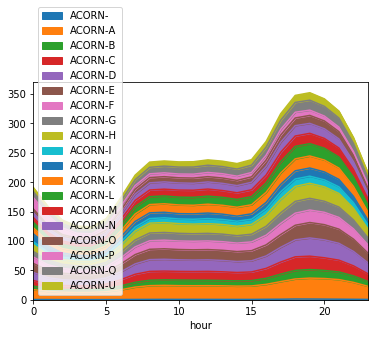

In [24]:
acorn_hourly_dataset.plot.area(x='hour')

## Работа с данными


### запрос всех данных потребителя по его LCLid

Функция пока не используется

In [3]:
LCLid_full_data = namedtuple(
    'LCLid_full_data',
    ['LCLid',
    'Acorn',  # Acorn category group
    'Acorn_grouped',  # common subdivision over Acorn groups
    'stdorToU',  # Standart or TimeOfUse
    'consumption']  # returns DataFrame
)

def retrieve_LCLid_full_data(LCLid):
# запрос всех данных потребителя по его LCLid
    LCLid_series = informations_households.loc[LCLid]
    file = LCLid_series['file']
    hh_ds_block = pd.read_csv(
        file_prefix / 'halfhourly_dataset' / f'{file}.csv.zip',
        parse_dates=['tstp'],
        infer_datetime_format=True,
        na_values='Null',
        keep_default_na=True,
        index_col='LCLid')
    hh_ds_block = hh_ds_block.loc[LCLid]
    hh_ds_block.fillna(0, inplace=True)
    hh_ds_block.columns = ['tstp', 'energy']
    # np.float16 is too rough even for thousandths
    hh_ds_block['energy'] = hh_ds_block['energy'].astype(np.float32, copy=False)

    return LCLid_full_data(
        LCLid=LCLid,
        Acorn=LCLid_series['Acorn'],
        Acorn_grouped=LCLid_series['Acorn_grouped'],
        stdorToU=LCLid_series['stdorToU'],
        consumption=hh_ds_block
    )

z = retrieve_LCLid_full_data('MAC003597')
# z.Acorn
# z.consumption.sample(5)
z.consumption.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24215 entries, MAC003597 to MAC003597
Data columns (total 2 columns):
tstp      24215 non-null datetime64[ns]
energy    24215 non-null float32
dtypes: datetime64[ns](1), float32(1)
memory usage: 472.9+ KB


### Сбор всех данных из получасовых отсчётов в один датафрейм

Ну что ж, как показала практика, даже гугловский колаб крэшится из-за недостатка памяти.
Придётся обрабатывать такие получасовки раздельно, предварительно преобразовав их в почасовое потребление.

Хотя памяти потребовалось не так уж и много, на самом деле.

Оставлено для истории.

```
DEBUG: concatenated dataframe info
<class 'pandas.core.frame.DataFrame'>
Index: 83925602 entries, MAC000002 to MAC005523
Data columns (total 2 columns):
tstp      object
energy    float32
dtypes: float32(1), object(1)
memory usage: 1.6+ GB
None
```



In [0]:
consumption = pd.DataFrame(columns=['tstp','energy'])

for file in glob.glob(str(file_prefix / 'halfhourly_dataset' / '*.*')):
    print(f'DEBUG: file={file}')
    temp = pd.read_csv(
        file,
        parse_dates=['tstp'],
        infer_datetime_format=True,
        na_values='Null',
        keep_default_na=True,
        # index_col='LCLid' # we'll do it later
    )
    temp.columns = ['LCLid', 'tstp', 'energy']
    temp.fillna(0, inplace=True)
    # np.float16 is too rough even for thousandths
    temp['energy'] = temp['energy'].astype(np.float32, copy=False)
    # now we need to concatenate two halves of an hour
    # roughing to hours
    temp['tstp'] = temp['tstp'].dt.to_period('H')
    # grouping, summing and regrouping back one level,
    # so LCLid stays as an index
    consumption = pd.concat(
        [consumption,
         temp.groupby(by=['LCLid', 'tstp']).agg(np.sum).reset_index(['tstp'])
         ], copy=False)

    # for testing with small amount of data
    # count_tables += 1
    # if count_tables > 5:
    #     break
    
# display(consumption.sample(10))
print('DEBUG: concatenated dataframe info')
display(consumption.info())

# save it to the google disk
# do we really need this? omg, i don't know
# it's just for lulz, mate
print('DEBUG: pickling concatenated dataframe to disk')
pd.to_pickle(
    consumption,
    file_prefix / 'hourly_dataset' / 'hourly_dataset.pickle.zip', 
    compression='zip',
    protocol=4)


### пример чтения списка файлов из папки на Google disk

In [0]:
file_path = glob.glob(str(file_prefix / 'halfhourly_dataset' / '*.*'))
for file in file_path:
    print(file)

### закрытие файлов на Google disk

In [0]:
drive.flush_and_unmount()